In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.tools.plotting import parallel_coordinates

import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})
# rcParams['figure.figsize'] = 12, 4
from scipy import stats
import math


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

from sklearn import preprocessing

D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [17]:
#test
xls = pd.ExcelFile('2014年基本信息表.xls')
data_upperHalf = xls.parse('基本信息表2014上半年')
data_lowerHalf = xls.parse('基本信息表2014下半年')
data_orig = pd.DataFrame()
data_orig = pd.concat([data_upperHalf,data_lowerHalf],ignore_index=True)

xls = pd.ExcelFile('2015年基本信息表.xls')
data_upperHalf = xls.parse('基本信息表2015年上半年')
data_lowerHalf = xls.parse('基本信息表2015年上半年')
data_orig = pd.concat([data_orig,data_upperHalf,data_lowerHalf],ignore_index=True)

xls = pd.ExcelFile('2016年基本信息表.xls')
data_upperHalf = xls.parse('2016年上半年基本信息表')
data_lowerHalf = xls.parse('2016年下半年基本信息表')
data_orig = pd.concat([data_orig,data_upperHalf,data_lowerHalf],ignore_index=True)
xls.close()

del data_upperHalf
del data_lowerHalf

print(data_orig.groupby(['路号']).size())

路号
4.0         4470
15.0       16019
25.0        2239
94.0         260
10107.0     7798
10205.0      422
20300.0      638
22090.0     1361
22700.0      345
22800.0     3914
23000.0     2294
23100.0     2742
23300.0     1200
30019.0        1
30025.0        1
30089.0       91
30090.0        4
30094.0        3
50001.0      542
50002.0     1597
50003.0        8
50004.0      508
50012.0        4
50076.0     5227
50096.0       50
50125.0      283
50139.0        4
50510.0       10
50511.0        1
50515.0        3
           ...  
98074.0        1
98101.0        2
98104.0       27
98105.0       22
98106.0       52
98107.0      139
98201.0        2
98202.0       31
98203.0       55
98204.0       74
98205.0        3
98206.0        6
98207.0        8
98209.0        2
98212.0        2
98213.0        6
98214.0       38
98216.0       10
98218.0        5
98220.0        1
98222.0        1
98337.0        6
98576.0        1
98589.0        1
98592.0        1
98662.0        2
98685.0        2
98854.0    

In [2]:
data = pd.read_excel('data_accidentForPapaer_17.11.13.xlsx')
data = data[data['路面附着系数'].isnull()]
print(len(data))
data_roadGrade_withoutJianyi = data[~data['事故类型'].isin(['简易程序事故'])]
print(len(data_roadGrade_withoutJianyi))

196169
3052


In [3]:
# nan_columns = {}
# length_data = len(data_roadGrade_withoutJianyi)
# for i in range(len(data_roadGrade_withoutJianyi.columns)): 
#     odds = sum(data_roadGrade_withoutJianyi[data_roadGrade_withoutJianyi.columns[i]].isnull())/length_data
#     nan_columns[data_roadGrade_withoutJianyi.columns[i]] = odds

# j = 0
# for i in nan_columns:
#     print(i+': '+str(nan_columns[i]),end='  ')
#     j+=1
#     if j==4:
#         j=0
#         print()

中央隔离设施: 0.35878112713  是否节假日: 0.211336828309  是否白天: 0.211336828309  事故地点: 0.0  
事故多发点段: 0.00819134993447  事故类型: 0.0  交通信号方式（控制）: 0.000655307994758  交通标志标线完善: 0.0  
公路行政等级: 0.424311926606  公里数: 0.000327653997379  其他交通安全设施不全: 0.00819134993447  单向路宽: 0.543577981651  
双向路宽: 0.841415465269  在道路横断面位置: 0.000655307994758  地形: 0.00229357798165  天气: 0.0  
所辖乡镇: 0.00360419397117  星期: 0.0  是否运载危险物品: 0.0  照明条件: 0.000655307994758  
能见度: 0.0314547837484  行政区划: 0.0  路侧防护设施类型: 0.0157273918742  路口路段类型: 0.00327653997379  
路号: 0.0  路表情况: 0.000655307994758  路面状况: 0.000655307994758  路面结构: 0.00262123197903  
路面附着系数: 1.0  道路安全属性: 0.199213630406  道路安全隐患督办等级: 0.397116644823  道路物理隔离: 0.00294888597641  
道路类型: 0.00163826998689  道路线型: 0.00229357798165  长下坡路段: 0.0  

In [8]:
# data_roadGrade_withoutJianyi.drop(['路面附着系数'],axis=1,inplace=True)
data_roadGrade_withoutJianyi \
                        = data_roadGrade_withoutJianyi[data_roadGrade_withoutJianyi['是否节假日'].notnull()\
                        &data_roadGrade_withoutJianyi['事故多发点段'].notnull()\
                        &data_roadGrade_withoutJianyi['交通信号方式（控制）'].notnull()\
                        &data_roadGrade_withoutJianyi['公里数'].notnull()\
                        &data_roadGrade_withoutJianyi['其他交通安全设施不全'].notnull()\
                        &data_roadGrade_withoutJianyi['在道路横断面位置'].notnull()\
                        &data_roadGrade_withoutJianyi['地形'].notnull()\
                        &data_roadGrade_withoutJianyi['所辖乡镇'].notnull()\
                        &data_roadGrade_withoutJianyi['照明条件'].notnull()\
                        &data_roadGrade_withoutJianyi['能见度'].notnull()\
                        &data_roadGrade_withoutJianyi['路侧防护设施类型'].notnull()\
                        &data_roadGrade_withoutJianyi['路口路段类型'].notnull()\
                        &data_roadGrade_withoutJianyi['路表情况'].notnull()\
                        &data_roadGrade_withoutJianyi['路面状况'].notnull()\
                        &data_roadGrade_withoutJianyi['路面结构'].notnull()\
                        &data_roadGrade_withoutJianyi['道路安全属性'].notnull()\
                        &data_roadGrade_withoutJianyi['道路安全隐患督办等级'].notnull()\
                        &data_roadGrade_withoutJianyi['道路物理隔离'].notnull()\
                        &data_roadGrade_withoutJianyi['道路类型'].notnull()\
                        &data_roadGrade_withoutJianyi['道路线型'].notnull()]

In [10]:
# nan_columns = {}
# length_data = len(data_roadGrade_withoutJianyi)
# for i in range(len(data_roadGrade_withoutJianyi.columns)): 
#     odds = sum(data_roadGrade_withoutJianyi[data_roadGrade_withoutJianyi.columns[i]].isnull())/length_data
#     nan_columns[data_roadGrade_withoutJianyi.columns[i]] = odds

# j = 0
# for i in nan_columns:
#     print(i+': '+str(nan_columns[i]),end='  ')
#     j+=1
#     if j==4:
#         j=0
#         print()
data_roadGrade_withoutJianyi.columns

Index(['中央隔离设施', '是否节假日', '是否白天', '是否双道', '路宽', '事故地点', '事故多发点段', '事故类型',
       '交通信号方式（控制）', '交通标志标线完善', '公路行政等级', '公里数', '其他交通安全设施不全', '在道路横断面位置',
       '地形', '天气', '所辖乡镇', '星期', '是否运载危险物品', '照明条件', '能见度', '行政区划', '路侧防护设施类型',
       '路口路段类型', '路号', '路表情况', '路面状况', '路面结构', '道路安全属性', '道路安全隐患督办等级',
       '道路物理隔离', '道路类型', '道路线型', '长下坡路段'],
      dtype='object')

# 整合路宽

In [11]:
data_way = data_roadGrade_withoutJianyi[['单向路宽','双向路宽']]
data_way.columns=['oneWay','twoWay']

#填充空值为-1
data_way.fillna(-1,inplace=True)

def isTwowayRoad(row,oneWay,twoWay):
    if row[oneWay] == -1 and row[twoWay] == -1:
        return np.nan
    elif row[oneWay] == -1:
        return '是'
    elif  row[twoWay] == -1:
        return  '否'

def getRoadWidth(row,oneWay,twoWay):
    if row[oneWay] == -1 and row[twoWay] == -1:
        return np.nan
    elif row[oneWay] == -1:
        return row[twoWay]
    elif  row[twoWay] == -1:
        return  row[oneWay]

data_isTwoWay = pd.DataFrame(data_way.apply(isTwowayRoad, axis=1, oneWay='oneWay', twoWay='twoWay'),\
                             columns=['isTwoWay'])
data_roadWidth = pd.DataFrame(data_way.apply(getRoadWidth, axis=1, oneWay='oneWay', twoWay='twoWay'),\
                             columns=['roadWidth'])

data_roadGrade_withoutJianyi.insert(value=data_isTwoWay,column='是否双道',loc=3)
data_roadGrade_withoutJianyi.insert(value=data_roadWidth,column='路宽',loc=4)

# pd.DataFrame(data_attach_notnull[(data_attach_notnull['路宽']==-1)])[['是否双道','路宽','单向路宽','双向路宽']]
data_roadGrade_withoutJianyi.drop(['单向路宽','双向路宽'],axis=1,inplace=True)
del data_way,data_isTwoWay,data_roadWidth

nan_columns = {}
length_data = len(data_roadGrade_withoutJianyi)
for i in range(len(data_roadGrade_withoutJianyi.columns)): 
    odds = sum(data_roadGrade_withoutJianyi[data_roadGrade_withoutJianyi.columns[i]].isnull())/length_data
    nan_columns[data_roadGrade_withoutJianyi.columns[i]] = odds

j = 0
for i in nan_columns:
    print(i+': '+str(nan_columns[i]),end='  ')
    j+=1
    if j==4:
        j=0
        print()

In [5]:
print(len(data_roadGrade_withoutJianyi))

1373


# 处理缺失特征

In [12]:
data_roadGrade_withoutJianyi = data_roadGrade_withoutJianyi[data_roadGrade_withoutJianyi['是否双道'].notnull()\
                                                        &data_roadGrade_withoutJianyi['中央隔离设施'].notnull()]
print(len(data_roadGrade_withoutJianyi))
data_roadGrade_withoutJianyi.drop(['公路行政等级'],axis=1,inplace=True)

774


D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [15]:
data_roadGrade_withoutJianyi.to_excel('data_roadGrade_withoutJianyi_17.11.15.xlsx')

In [13]:
# nan_columns = {}
# length_data = len(data_roadGrade_withoutJianyi)
# for i in range(len(data_roadGrade_withoutJianyi.columns)): 
#     odds = sum(data_roadGrade_withoutJianyi[data_roadGrade_withoutJianyi.columns[i]].isnull())/length_data
#     nan_columns[data_roadGrade_withoutJianyi.columns[i]] = odds
# j = 0
# for i in nan_columns:
#     print(i+': '+str(nan_columns[i]),end='  ')
#     j+=1
#     if j==4:
#         j=0
#         print()
        
# print(len(data_roadGrade_withoutJianyi))

# 获取某路号出现最多的道路相关属性

In [72]:
# len(data_roadGrade_withoutJianyi.groupby(['路号']))
info = {}
roadColumns = ['事故多发点段','交通信号方式','交通标志标线完善','其他交通安全设施不全','路侧防护设施类型',\
               '路口路段类型','路面状况','路面结构','交通信号方式（控制）',\
               '道路安全属性','道路安全隐患督办等级','道路物理隔离','道路类型','道路线型','长下坡路段']
data_gbRoadNo = data_roadGrade_withoutJianyi.groupby(['路号'])
for name,group in data_gbRoadNo:
#     print(name)
    group = pd.DataFrame(group)
    for i in group.columns:
        if i in roadColumns:
            info[i] = group[i].value_counts().index[0]
    break
    
# 事故多发点段,交通信号方式,交通标志标线完善,其他交通安全设施不全,路侧防护设施类型,路口路段类型,路面状况,路面结构,
# 道路安全属性,道路安全隐患督办等级,道路物理隔离,道路类型,道路线型,长下坡路段

In [73]:
info

{'事故多发点段': 2.0,
 '交通信号方式（控制）': 45,
 '交通标志标线完善': '否',
 '其他交通安全设施不全': '否',
 '路侧防护设施类型': '无防护',
 '路口路段类型': '普通路段',
 '路面状况': '路面完好',
 '路面结构': '沥青',
 '道路安全属性': '正常路段',
 '道路安全隐患督办等级': 4.0,
 '道路物理隔离': '中心隔离',
 '道路类型': '高速',
 '道路线型': '平直',
 '长下坡路段': '否'}

# 测试三个缺省属性是否关联
## 结果关联程度不大

In [15]:
print(len(data_roadGrade_withoutJianyi))
data_roadGrade_withoutJianyi_2 = data_roadGrade_withoutJianyi[data_roadGrade_withoutJianyi['是否双道'].notnull()]
nan_columns = {}
length_data = len(data_roadGrade_withoutJianyi_2)
for i in range(len(data_roadGrade_withoutJianyi_2.columns)): 
    odds = sum(data_roadGrade_withoutJianyi_2[data_roadGrade_withoutJianyi_2.columns[i]].isnull())/length_data
    nan_columns[data_roadGrade_withoutJianyi_2.columns[i]] = odds

j = 0
for i in nan_columns:
    print(i+': '+str(nan_columns[i]),end='  ')
    j+=1
    if j==4:
        j=0
        print()
        
print(len(data_roadGrade_withoutJianyi_2))

1373
中央隔离设施: 0.206153846154  是否节假日: 0.0  是否白天: 0.0  是否双道: 0.0  
路宽: 0.0  事故地点: 0.0  事故多发点段: 0.0  事故类型: 0.0  
交通信号方式（控制）: 0.0  交通标志标线完善: 0.0  公路行政等级: 0.4  公里数: 0.0  
其他交通安全设施不全: 0.0  在道路横断面位置: 0.0  地形: 0.0  天气: 0.0  
所辖乡镇: 0.0  星期: 0.0  是否运载危险物品: 0.0  照明条件: 0.0  
能见度: 0.0  行政区划: 0.0  路侧防护设施类型: 0.0  路口路段类型: 0.0  
路号: 0.0  路表情况: 0.0  路面状况: 0.0  路面结构: 0.0  
道路安全属性: 0.0  道路安全隐患督办等级: 0.0  道路物理隔离: 0.0  道路类型: 0.0  
道路线型: 0.0  长下坡路段: 0.0  975


# 如何填充公路行政等级

# 预测

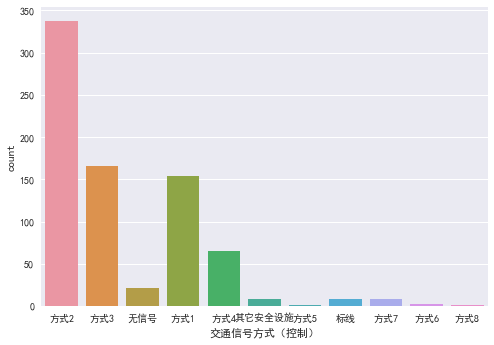

In [26]:
#交通信号方式（控制）
sns.countplot(data_roadGrade_withoutJianyi['交通信号方式（控制）'])
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==345,'交通信号方式（控制）']='方式1'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==45,'交通信号方式（控制）']='方式2'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==456,'交通信号方式（控制）']='方式3'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==3456,'交通信号方式（控制）']='方式4'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==16,'交通信号方式（控制）']='方式5'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==34,'交通信号方式（控制）']='方式6'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==56,'交通信号方式（控制）']='方式7'
data_roadGrade_withoutJianyi.loc[data_roadGrade_withoutJianyi['交通信号方式（控制）']==356,'交通信号方式（控制）']='方式8'

sns.countplot(data_roadGrade_withoutJianyi['交通信号方式（控制）'])
#删除星期
data_roadGrade_withoutJianyi.drop(['星期'],axis=1,inplace=True)

In [27]:
#生成训练集和测试集
columnsToNum = list(data_roadGrade_withoutJianyi.columns)

data_roadGrade_withoutJianyi_toNum = pd.DataFrame()
for i in columnsToNum:
    data_roadGrade_withoutJianyi_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_roadGrade_withoutJianyi[i])



In [28]:
target = '事故类型'

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):  
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='merror', early_stopping_rounds=early_stopping_rounds)#, show_progress=False，多分类metrics使用merror
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors],dtrain[target],eval_metric='merror')    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        



    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
#     print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

    cvresult = pd.DataFrame(cvresult)
    print("Accuracy : %.4g" % (1-cvresult.iloc[-1][0]))
    print('test-auc-mean and test-auc-std and train-auc-mean and train-auc-std:')
    print(cvresult.iloc[-1][:])#
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    return alg


Model Report
Accuracy : 0.9987
Accuracy : 0.7273
test-auc-mean and test-auc-std and train-auc-mean and train-auc-std:
test-merror-mean     0.272727
test-merror-std      0.028155
train-merror-mean    0.000000
train-merror-std     0.000000
Name: 207, dtype: float64


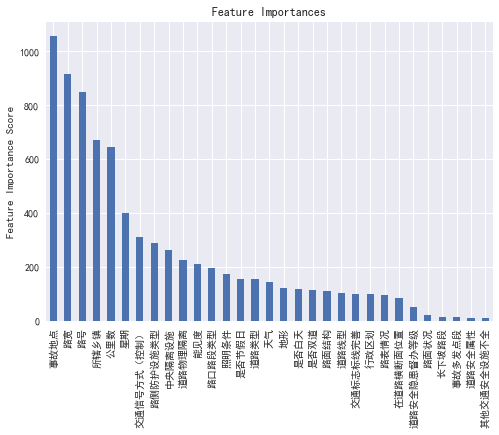

In [29]:
#Choose all predictors except target & IDcols
predictors = [x for x in data_roadGrade_withoutJianyi_toNum.columns if x not in [target]]
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=4,
    min_child_weight=0,
    gamma=0,
    subsample=0.6,
    colsample_bytree=0.7,
    #  reg_alpha=0.005,
    objective= 'multi:softmax',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
alg = modelfit(xgb1, data_roadGrade_withoutJianyi_toNum, predictors)

### 1.2.1 调参

In [ ]:
param_test1 = {
 'max_depth':list(range(3,10,1)),
 'min_child_weight':list(range(1,10,1))
}
# learning_rate =0.1,
#     n_estimators=1000,
#     max_depth=4,
#     min_child_weight=0,
#     gamma=0,
#     subsample=0.6,
#     colsample_bytree=0.7,
#     #  reg_alpha=0.005,
#     objective= 'multi:softmax',
#     nthread=4,
#     scale_pos_weight=1,
#     seed=27
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=0.005,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)

gsearch1.fit(data_roadGrade_notNull_withoutJianyi_toNum[predictors],data_roadGrade_notNull_withoutJianyi_toNum[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

#{'max_depth': 9, 'min_child_weight': 2},
 #0.6770666217228164)

In [ ]:
param_test1b = {
 'max_depth':[7,8,9,10,11]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=0.005,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1b, scoring='accuracy',n_jobs=4,iid=False, cv=5)

gsearch1.fit(data_roadGrade_notNull_withoutJianyi_toNum[predictors],data_roadGrade_notNull_withoutJianyi_toNum[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

#max_depth=9